In [1]:
#import needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from matplotlib.pyplot import MultipleLocator
import os
from os.path import dirname

In [2]:
#read in Bitcoin dataframe
parent_dir = os.path.dirname(os.getcwd())
traincsv = pd.read_csv(parent_dir + "/data/BTC ML Final.csv", header=0)
df = pd.DataFrame(traincsv)
window=5
time1=df.iloc[window+1:,0].to_numpy()
ret=df.iloc[window+1:,5].to_numpy()
df.head()

,Date,HL,OC,AdjClose,Volume,ChangePer,UpDownSign,RSI,STCK,STCD,WILLS,MACD,ROCP,OBV,volatility
0,18/10/2014,0.042713,-0.019444,391.441986,11416800.0,1.962996,0,75.469711,0.760150,0.835494,-0.239850,-3.865832,-0.037463,-17386392.0,0.060301
1,19/10/2014,0.019360,0.004365,389.545990,5914570.0,-0.486719,0,79.658723,0.706411,0.793553,-0.293589,-2.739588,-0.097958,-23300962.0,0.060942
2,20/10/2014,0.031281,0.016407,382.845001,16419000.0,-1.750314,1,73.241668,0.192464,0.678191,-0.807536,-2.360535,-0.055866,-39719962.0,0.055016
3,21/10/2014,0.031016,-0.010601,386.475006,14188900.0,0.939260,0,72.644511,0.213990,0.565904,-0.786010,-1.747082,-0.050244,-25531062.0,0.046441
4,22/10/2014,0.016552,0.007666,383.157990,11641300.0,-0.865705,0,65.480216,0.032870,0.441208,-0.967130,-1.511153,-0.095417,-37172362.0,0.045207


In [3]:
#drop out unwanted data
df.drop(df.columns[[0]], axis=1, inplace=True) 
order = ['HL', 'OC','Volume','ChangePer','UpDownSign','RSI','STCK','STCD ','WILLS','MACD','ROCP', 'OBV','volatility','AdjClose']
df=df[order]
df.head()

,HL,OC,Volume,ChangePer,UpDownSign,RSI,STCK,STCD,WILLS,MACD,ROCP,OBV,volatility,AdjClose
0,0.042713,-0.019444,11416800.0,1.962996,0,75.469711,0.760150,0.835494,-0.239850,-3.865832,-0.037463,-17386392.0,0.060301,391.441986
1,0.019360,0.004365,5914570.0,-0.486719,0,79.658723,0.706411,0.793553,-0.293589,-2.739588,-0.097958,-23300962.0,0.060942,389.545990
2,0.031281,0.016407,16419000.0,-1.750314,1,73.241668,0.192464,0.678191,-0.807536,-2.360535,-0.055866,-39719962.0,0.055016,382.845001
3,0.031016,-0.010601,14188900.0,0.939260,0,72.644511,0.213990,0.565904,-0.786010,-1.747082,-0.050244,-25531062.0,0.046441,386.475006
4,0.016552,0.007666,11641300.0,-0.865705,0,65.480216,0.032870,0.441208,-0.967130,-1.511153,-0.095417,-37172362.0,0.045207,383.157990


In [4]:
#normalizing the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(df)
df = pd.DataFrame(df)
df.columns=['HL', 'OC','Volume','ChangePer','UpDownSign','RSI','STCK','STCD ','WILLS','MACD','ROCP', 'OBV','volatility','AdjClose']
df.tail()

,HL,OC,Volume,ChangePer,UpDownSign,RSI,STCK,STCD,WILLS,MACD,ROCP,OBV,volatility,AdjClose
2335,0.055118,0.456523,0.125060,0.705901,0.0,0.768888,0.842607,0.970077,0.842607,0.715501,0.045337,0.845581,0.164980,0.968218
2336,0.131080,0.496987,0.189215,0.673674,0.0,0.611894,0.468346,0.893798,0.468346,0.687995,0.127313,0.822418,0.227425,0.912620
2337,0.087582,0.378946,0.170213,0.766099,1.0,0.660953,0.506680,0.823020,0.506680,0.671676,0.069318,0.845581,0.211167,0.927320
2338,0.115625,0.349064,0.171662,0.791709,1.0,0.659622,0.630440,0.769999,0.630440,0.678083,0.100882,0.868744,0.217896,0.961153
2339,0.133230,0.424267,0.161865,0.731053,0.0,0.699880,0.425895,0.687630,0.425895,0.669709,0.114203,0.845581,0.212604,0.944581


In [5]:
#set the amount of feature
feanum=14
#set the window of prediction
#the prediction is based on all the information observed within a window of 5 days
stock=df
seq_len=window
amount_of_features = len(stock.columns)
#turn the datafram into array
data = stock.values
#transform data according to window and features
#LSTM expect our data to be in a specific format, usually a 3D array.
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
result = np.array(result)
#split data into training data and testing data
cut=480
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:,13]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:,13]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

In [71]:
#LSTM model construction
d = 0.01
#initialize the neural network 
model = Sequential()
#add the Long Short-Term Memory layer
model.add(LSTM(128, input_shape=(window, feanum), return_sequences=True))
#add dropout layers that prevent overfitting 
model.add(Dropout(d))
#add the Long Short-Term Memory layer
model.add(LSTM(128, input_shape=(window, feanum), return_sequences=False))
#add dropout layers that prevent overfitting 
model.add(Dropout(d))
#add a densely connected neural network layer 
model.add(Dense(4,activation='relu')) 
model.add(Dense(1,activation='relu')) 
#compile model using the popular adam optimizer and set the loss as the mean_squarred_error
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs =100, batch_size = 32)

Epoch 1/100
58/58 [==============================] - 6s 12ms/step - loss: 0.0037 - accuracy: 5.3929e-04
Epoch 2/100
58/58 [==============================] - 1s 13ms/step - loss: 3.6357e-04 - accuracy: 1.0844e-04
Epoch 3/100
58/58 [==============================] - 1s 11ms/step - loss: 1.0249e-04 - accuracy: 3.3702e-04
Epoch 4/100
58/58 [==============================] - 1s 12ms/step - loss: 4.1777e-05 - accuracy: 9.1873e-04
Epoch 5/100
58/58 [==============================] - 1s 13ms/step - loss: 4.3544e-05 - accuracy: 5.1521e-04
Epoch 6/100
58/58 [==============================] - 1s 12ms/step - loss: 3.6083e-05 - accuracy: 3.0441e-04
Epoch 7/100
58/58 [==============================] - 1s 12ms/step - loss: 4.1890e-05 - accuracy: 8.7058e-04
Epoch 8/100
58/58 [==============================] - 1s 12ms/step - loss: 4.2671e-05 - accuracy: 1.4226e-04
Epoch 9/100
58/58 [==============================] - 1s 12ms/step - loss: 6.2472e-05 - accuracy: 9.7170e-04
Epoch 10/100
58/58 [============

In [72]:
#LSTM model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 128)            73216     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 205,321
Trainable params: 205,321
Non-trainable params: 0
________________________________________________

In [73]:
#model prediction outcome
y_train_predict=model.predict(X_train)[:,0]
y_train=y_train
y_test_predict=model.predict(X_test)[:,0]
y_test=y_test

In [74]:
#obtain prediction signals: 1=buy 0=sell
pred_signals=np.zeros(len(y_test_predict)-1)
for i in range(len(pred_signals)):
    if y_test_predict[i+1]>y_test_predict[i]:
        pred_signals[i]=1.0

In [75]:
len(pred_signals)

479

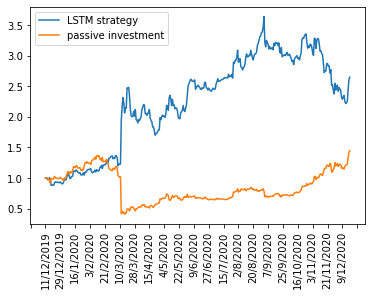

In [84]:
#trading strategy:1 long;0 short
#calculate trading strategy performance'
year_n=1
quarter_n=1
signals=pred_signals[-460:-90]
rets=ret[-460:-90]
length=len(signals)
value=np.zeros(length)
investment=np.zeros(length)
value[0]=1
investment[0]=1
for i in range(0,length-1):
    investment[i+1]=investment[i]*(1+0.01*rets[i+1])
    if signals[i]==1.0:
        value[i+1]=value[i]*(1+0.01*rets[i+1])
    else:
        value[i+1]=value[i]*(1-0.01*rets[i+1])

    
fig, ax=plt.subplots()
plt.plot(time1[-460:-90],value, label='LSTM strategy')
plt.plot(time1[-460:-90],investment,label='passive investment')
x_major_locator=MultipleLocator(18)
plt.xticks(rotation=90)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.legend()

In [80]:
# calculate trading strategy volatility and Sharpe ratio (annualised)
strategy_return=np.zeros(length)
for i in range(0,length-1):
    strategy_return[i]=value[i+1]/value[i]-1
std_strategy=strategy_return.std()*np.sqrt(length)
std_invest=ret.std()*np.sqrt(length)
ret_strategy=(value[-1]/value[0]-1)
ret_invest=(investment[-1]/investment[0]-1)
rf= 1.56/100 #10Y bond yield
SR_strategy=(ret_strategy-rf)/std_strategy
SR_invest=(ret_invest-rf)/std_invest
print("Return: strategy ",ret_strategy, " investment ", ret_invest)
print("Standard deviation: strategy ",std_strategy, " investment ", std_invest)
print("Sharpe ratio: strategy ",SR_strategy, " investment ", SR_invest)

Return: strategy  1.6467616220179666  investment  0.4445243358369191
Standard deviation: strategy  0.8431271621501758  investment  77.39210749981135
Sharpe ratio: strategy  1.934656710451736  investment  0.005542223227839669
